# **TRPO**

Trust Region policy optimization moving in a trusted region to improvement direction

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import warnings
import numpy as np

import gymnasium as gym
from gymnasium.wrappers import RescaleAction

import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings(action = 'ignore', category = UserWarning)

## **Device Setup**


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## **Env Setup**

In [4]:
env = gym.make('Humanoid-v5')

env = RescaleAction(env, min_action = -1.0, max_action = 1.0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

max_action = env.action_space.high[0]

print(f'State dim: {state_dim} | Action dim: {action_dim} | Max action: {max_action}')

State dim: 348 | Action dim: 17 | Max action: 1.0


## **Architecture**


In [5]:
class Feature_Extractor(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_size, hidden_size_2):
        super(Feature_Extractor, self).__init__()
        
        self.feature = nn.Sequential(
            
            nn.Linear(input_dim, hidden_size),
            nn.SiLU(),
            
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            
            
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            
            
            nn.Linear(hidden_size, hidden_size_2),
            nn.SiLU(),
            
            nn.Linear(hidden_size_2, hidden_size_2),
            nn.SiLU(),
            
            
            nn.Linear(hidden_size_2, output_dim),
            nn.SiLU()
        )
        
    def forward(self, x):
        
        return self.feature(x)

In [6]:
class Policy_Network(nn.Module):
    
    def __init__(self, state_dim, action_dim, head_1, head_2, head_3, head_4, hidden_size, hidden_size_2, max_action = max_action):
        super().__init__()
        
        self.max_action = max_action
        
        self.feature = Feature_Extractor(state_dim, head_1, hidden_size, hidden_size_2).to(device)
        
        self.actor = nn.Sequential(
            
            nn.Linear(head_1, head_2),
            nn.SiLU(),
            
            nn.LayerNorm(head_2),
            nn.Linear(head_2, head_3),
            nn.SiLU(),
            
            nn.LayerNorm(head_3),
            nn.Linear(head_3, head_4),
            nn.SiLU()
        )
        
        self.mu = nn.Linear(head_4, action_dim)
        
        self.log_std = nn.Linear(head_4, action_dim)
        
    def forward(self, state):
        
        feature = self.feature(state)
        
        actor = self.actor(feature)
        
        mu = self.mu(actor)
        log_std = self.log_std(actor)
        
        mu = torch.tanh_(mu)                # Range [- 1.0, 1.0]
        log_std = torch.tanh_(log_std)
        log_std = log_std.clamp(min = -10, max = 2)
        std = torch.exp(log_std)
        
        
        normal = torch.distributions.Normal(mu, std)
        z = normal.rsample()
        tanh_z = torch.tanh_(z)
        log_prob = normal.log_prob(z)
        action = tanh_z * self.max_action
        
        # Squashing
        
        squash = 2 * (torch.log(torch.tensor(2.0, device=z.device)) - z - F.softplus(-2 * z))
        log_prob = log_prob - squash
        log_prob = torch.sum(log_prob, dim = -1)
        
        return action, log_prob, mu, log_std

### **Value Network**


In [7]:
class Value_Network(nn.Module):
    
    def __init__(self, state_dim, head_1, head_2, head_3, head_4, hidden_size, hidden_size_2):
        super(Value_Network, self).__init__()
        
        self.feature = Feature_Extractor(state_dim, head_1, hidden_size, hidden_size_2)
        
        self.value_network = nn.Sequential(
            
            nn.Linear(head_1, head_2),
            nn.SiLU(),
            
            nn.LayerNorm(head_2),
            nn.Linear(head_2, head_3),
            nn.SiLU(),
            
            nn.LayerNorm(head_3),
            nn.Linear(head_3, head_4),
            nn.SiLU(),
            
            nn.Linear(head_4, 1)
        )
        
    def forward(self, state):
        
        feature = self.feature(state)
        
        value = self.value_network(feature)
        
        return value

### **Setup**


In [8]:
# Assembly

head_1 = 256
head_2 = 512
head_3 = 512
head_4 = 256

hidden_size = 256
hidden_size_2 = 512


# Policy Network

policy_network = Policy_Network(state_dim, action_dim, head_1, head_2, head_3, head_4, hidden_size, hidden_size_2).to(device)

print('-' * 70)
print(policy_network)

# Value Network

value_network = Value_Network(state_dim, head_1, head_2, head_3, head_4, hidden_size, hidden_size_2).to(device)

print('-' * 70)
print(value_network)

----------------------------------------------------------------------
Policy_Network(
  (feature): Feature_Extractor(
    (feature): Sequential(
      (0): Linear(in_features=348, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): SiLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): SiLU()
      (6): Linear(in_features=256, out_features=512, bias=True)
      (7): SiLU()
      (8): Linear(in_features=512, out_features=512, bias=True)
      (9): SiLU()
      (10): Linear(in_features=512, out_features=256, bias=True)
      (11): SiLU()
    )
  )
  (actor): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): SiLU()
    (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SiLU()
    (5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (6): Linear(in_features=512, out_features

## **Roller Buffer** + **PreComputed Advantage and Returns**

In [9]:
class Roller_buffer:
    
    def __init__(self):
        
        self.clear()
        
    def clear(self):
        
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        self.values = []
        
        # computed later
        
        self.advantages = []
        self.returns = []
        
    def store(self, state, action, reward, next_state, done, value):
        
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)
        self.values.append(value)
        
    def compute_gae(self, lam, gamma , value, rewards, dones, last_values):
                
        gae = 0
        advantages = []
        
        # Convert to tensors if needed
        
        values = torch.tensor(value + [last_values], dtype = torch.float32, device = device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)
        values = torch.tensor(values, dtype=torch.float32).to(device)
        
        for step in reversed(range(len(rewards))):
            
            delta_gae = rewards[step] + gamma * (1 - dones[step]) * values[step + 1] - values[step]
            gae = delta_gae + lam * gamma * (1 - dones[step]) * gae
            
            advantages.append(gae)
            
        advantages = advantages[::-1]
        
        returns = [adv + val for adv, val in zip(advantages, values)]
        
        return advantages, returns
    

### **Setup**


In [10]:
roller_buffer = Roller_buffer()

## **TRPO's GOD Loss Function**


In [11]:
class TRPO_GOD_Loss_Function:
    
    def __init__(self, policy_network, gamma, gae_lambda, max_kl, accept_ratio, max_back_tracks, entropy_coef):
        
        self.policy_network = policy_network
        
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.max_kl = max_kl
        self.accept_ratio = accept_ratio
        self.max_back_tracks = max_back_tracks
        self.entropy_coef = entropy_coef
        
    def surrogate_loss_function(self, advantages, states, old_log_probs, entropy_coef):
            
        _ , log_prob, mu, log_std = self.policy_network(states)
        
        std = torch.exp(log_std)
            
        dist = torch.distributions.Normal(mu, std)
            
            
        ratio = torch.exp(log_prob - old_log_probs)
            
        surrogate_loss = (ratio * advantages).mean()
        
        entropy = dist.entropy().mean()
        
        total_loss = -surrogate_loss - entropy_coef * entropy
        
        return total_loss
    
    def compute_KL_Divergernce(self, states):
        
        with torch.no_grad():
            
            _, _ , mu_old, log_std_old = self.policy_network(states)
            
        _, _, new_mu, log_std_new = self.policy_network(states)
        
        std_old = torch.exp(log_std_old)
        std_new = torch.exp(log_std_new)
    
        KL_Div = (
            
            log_std_old - log_std_new + 
            (std_old.pow(2) + (mu_old - new_mu).pow(2)) / (2.0 * std_new.pow(2)) - 0.5
        )
        
        return KL_Div.sum(dim = 1).mean()
    
    
    def conjugate_gradient(self, Av_function, b, max_iter = 10, tolerance = 1e-10):
        
        x = torch.zeros_like(b)                                 # We know nothing
        r = b.clone()                                           # This here is residual
        p = b.clone()                                           # Moving in the direction
        rs_old = torch.dot(r, r)                                # this L2 Squared residual
        
        for _ in range(max_iter):
            
            Ap = Av_function(p)                                 # Fisher Vector Product
            
            alpha = rs_old / (torch.dot(p, Ap) + 1e-8)          # How much we are moving in p direction for fisher vector
            
            x += alpha * p                                      # How much we are improving
            r -= alpha * Ap                                     # Residual Decreased
            
            rs_new = torch.dot(r, r)                            # New Residual
            
            if rs_new < tolerance:
                
                break                                            # Early exit before Convergence
            
            p = r + (rs_new / rs_old) * p                        # Slowly p = p if converging
            rs_old = rs_new                                      # Update Residual
            
        return x                                                 # Solution
    
    
    def fisher_vector_product(self, vector, states, damping = 1e-2):
        
        _, _, mu, log_std = self.policy_network(states)
        
        std = torch.exp(log_std)
        
        dist = torch.distributions.Normal(mu, std)
        
        # Compute kl div 
        
        kl = torch.distributions.kl_divergence(dist, dist).mean()
        
        # compute first gradient
        
        kl_grad = torch.autograd.grad(kl, self.policy_network.parameters(), create_graph = True)
        flat_kl_grad = torch.cat([grad.view(-1) for grad in kl_grad])
        
        # Compute flat_kl_grad * vector
        
        kl_v = (flat_kl_grad * vector).sum()
        
        # compute second order gradient
        
        kl_grad_2 = torch.autograd.grad(kl_v, self.policy_network.parameters(), retain_graph = True)
        flat_kl_grad_2 = torch.cat([g.contiguous().view(-1) for g in kl_grad_2])
        
        return flat_kl_grad_2 + damping * vector
    
    
    def get_loss_kl(self, states, advantages, old_log_probs):
        
            
        loss = self.surrogate_loss_function(advantages, states, old_log_probs, self.entropy_coef)
        kl = self.compute_KL_Divergernce(states)
            
        return loss.item(), kl.item()
        
            
            
    def line_search(self, full_steps, states, advantages, old_log_probs):
        
        prev_params = torch.nn.utils.parameters_to_vector(self.policy_network.parameters()).detach()
        
        for step in [0.5 * i for i in range(self.max_back_tracks)]:
            
            new_params = prev_params + step * full_steps
            
            torch.nn.utils.vector_to_parameters(new_params, self.policy_network.parameters())
            
            loss, kl = self.get_loss_kl(states, advantages, old_log_probs)
            
            if loss < 0 and kl < self.max_kl:
                
                return True, new_params
            
        torch.nn.utils.vector_to_parameters(prev_params, self.policy_network.parameters())
        return False, prev_params

### **Setup**

In [ ]:
# Params

gamma = 0.997
gae_lambda = 0.99
max_kl = 0.3
accept_ratio = 0.01
max_back_tracks = 20 
entropy_coef = 0.01



loss_function = TRPO_GOD_Loss_Function(policy_network, gamma, gae_lambda, max_kl, accept_ratio, max_back_tracks, entropy_coef)

## **TRPO Agent**

In [13]:
class TRPO_AGENT:
    
    def __init__(self, policy_network, value_network, value_optimizer, value_scheduler, roller_buffer, lam, gamma, max_kl, entropy_coef, loss_function = loss_function):
        
        self.policy_network = policy_network
        self.value_network = value_network
        self.loss_function = loss_function
        
        self.value_opt = value_optimizer
        self.value_sch = value_scheduler
        
        self.buffer = roller_buffer
        
        self.gamma = gamma
        self.gae_lambda = lam
        self.max_kl = max_kl
        self.entropy_coef = entropy_coef
        self.succeeded = 0
        #self.entropy_coef = max(0.01, self.entropy_coef * 0.995)
        
    def update(self, trajectories):
        
        states = torch.stack(trajectories['states']).to(device)
        actions = torch.stack(trajectories['actions'])
        rewards = torch.tensor(trajectories['rewards'] , dtype = torch.float32).to(device)
        dones = torch.tensor(trajectories['dones'], dtype = torch.float32).to(device)
        next_states = torch.stack(trajectories['next_states']).to(device)
        
        with torch.no_grad():
            
            values = self.value_network(states).squeeze(-1)
            values = values.cpu().numpy().tolist()
            
        # Compute advantages and returns
        
        with torch.no_grad():
            
            last_state = next_states[-1].unsqueeze(0).to(device)
            last_values = self.value_network(last_state).item() 
        
        advantages, targets = self.buffer.compute_gae(self.gae_lambda, self.gamma, values, rewards, dones, last_values)
        
        advantages = torch.tensor(advantages, dtype = torch.float32).to(device)
        targets = torch.tensor(targets, dtype = torch.float32).to(device)
        
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        
        # Old log_probs
        
        _, old_log_probs, _, _ = self.policy_network(states)
        
        surrogate_loss = self.loss_function.surrogate_loss_function(advantages, states, old_log_probs, self.entropy_coef)
        
        # compute policy gradient (b)
        
        grads = torch.autograd.grad(surrogate_loss, self.policy_network.parameters())
        flat_grads = torch.cat([g.view(-1) for g in grads])

        # Compute step direction
        
        Av_func = lambda v: self.loss_function.fisher_vector_product(v, states)
        step_direction = self.loss_function.conjugate_gradient(Av_func, flat_grads)   
        
        # Scale for trust region
        
        step_scale = (2 * self.max_kl / (step_direction.dot(Av_func(step_direction)) + 1e-8 )) ** 0.5
        full_step = step_scale * step_direction
        
        # Line search
        
        success, new_params = self.loss_function.line_search(full_step, states, advantages, old_log_probs)
        
        print("Line search success:", success)
        
        if success is True:
            
            self.succeeded += 1

        
        if success:
            
            torch.nn.utils.vector_to_parameters(new_params, self.policy_network.parameters())
            
        # Update Value network
        
        for _ in range(10):
            
            value = self.value_network(states).squeeze()
            value_loss = F.mse_loss(value, targets)
            self.value_opt.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.value_network.parameters(), max_norm = 0.5)
            self.value_opt.step()
            self.value_sch.step()
            
        return value_loss.item(), self.succeeded
        

In [14]:
# Hyper params

lr = 1e-4
T_max = 3000

value_optimizer = optim.AdamW(value_network.parameters(), lr, weight_decay = 0.001)
value_scheduler = optim.lr_scheduler.CosineAnnealingLR(value_optimizer, T_max)


# Agent setup

Trpo_Agent = TRPO_AGENT(policy_network, value_network, value_optimizer, value_scheduler, roller_buffer, gae_lambda, gamma, max_kl, entropy_coef)



In [15]:
def shaped_reward(reward , state):
    
    is_falling = (state[2] < 0.8 or          # Height threshold
                 abs(state[3]) > 0.4 or      # Angular velocity X
                 abs(state[4]) > 0.4)        # Angular velocity Y
    
    if is_falling:
        
        recovery_bonus = 3.0 * (1 - abs(state[3]))
        survival_bonus = 0.5 * (0.8 - state[2])
        reward += recovery_bonus + survival_bonus
    
    else:
        
        reward += 0.05
        reward += 1.5 * state[1]
        reward += 0.3 * state[2] ** 2 # Height bonus quadritic
        reward += 1.5 * state[0] * (1 + state[2])   # Forward locomotion
        reward -= 0.1 * np.square(state[3:6]).sum()  # Angular penalty
        reward -= 0.1 * (state[3] ** 2 + state[4] ** 2)
        
    return reward / 10.0

In [16]:
def train_trpo(env, agent, max_episodes, max_timesteps):
    episode_rewards = []
    max_reward = -np.inf

    for episode in range(max_episodes):
        state, _ = env.reset()
        trajectory = {'states': [], 'actions': [], 'rewards': [], 'dones': [], 'next_states': []}
        total_reward = 0

        for t in range(max_timesteps):
            
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                action, _, _, _ = agent.policy_network(state_tensor)
                action = action.squeeze().cpu().numpy()

            next_state, reward, done, _, _ = env.step(action)

            # Store trajectory
            trajectory['states'].append(torch.tensor(state, dtype=torch.float32))
            trajectory['actions'].append(torch.tensor(action, dtype=torch.float32))
            trajectory['next_states'].append(torch.tensor(next_state, dtype = torch.float32))
            trajectory['rewards'].append(reward)
            trajectory['dones'].append(done)

            reward = shaped_reward(reward, state)
            total_reward += reward
            state = next_state
            

            if done:
                
                if total_reward > max_reward:
                    
                    max_reward = total_reward
                    torch.save(agent.policy_network.state_dict(), 'best_policy.pt')
                    
                break

        episode_rewards.append(total_reward)

        # Train after collecting trajectory
        _, succeeded = agent.update(trajectory)

        print(f"Episode {episode+1} | Total Reward: {total_reward:.2f} | Max reward: {max_reward}")
        print(" ")
        print(f'Success: {succeeded}')
    return episode_rewards


In [17]:
episode_reward = train_trpo(env, Trpo_Agent, max_episodes = 3000, max_timesteps = 1024)

Line search success: True
Episode 1 | Total Reward: 14.75 | Max reward: 14.750010729525734
 
Success: 1
Line search success: True
Episode 2 | Total Reward: 29.16 | Max reward: 29.164750402961573
 
Success: 2
Line search success: True
Episode 3 | Total Reward: 15.14 | Max reward: 29.164750402961573
 
Success: 3
Line search success: True
Episode 4 | Total Reward: 16.76 | Max reward: 29.164750402961573
 
Success: 4
Line search success: True
Episode 5 | Total Reward: 26.21 | Max reward: 29.164750402961573
 
Success: 5
Line search success: True
Episode 6 | Total Reward: 27.79 | Max reward: 29.164750402961573
 
Success: 6
Line search success: True
Episode 7 | Total Reward: 30.17 | Max reward: 30.172455716381293
 
Success: 7
Line search success: True
Episode 8 | Total Reward: 22.26 | Max reward: 30.172455716381293
 
Success: 8
Line search success: True
Episode 9 | Total Reward: 27.36 | Max reward: 30.172455716381293
 
Success: 9
Line search success: True
Episode 10 | Total Reward: 18.01 | Max

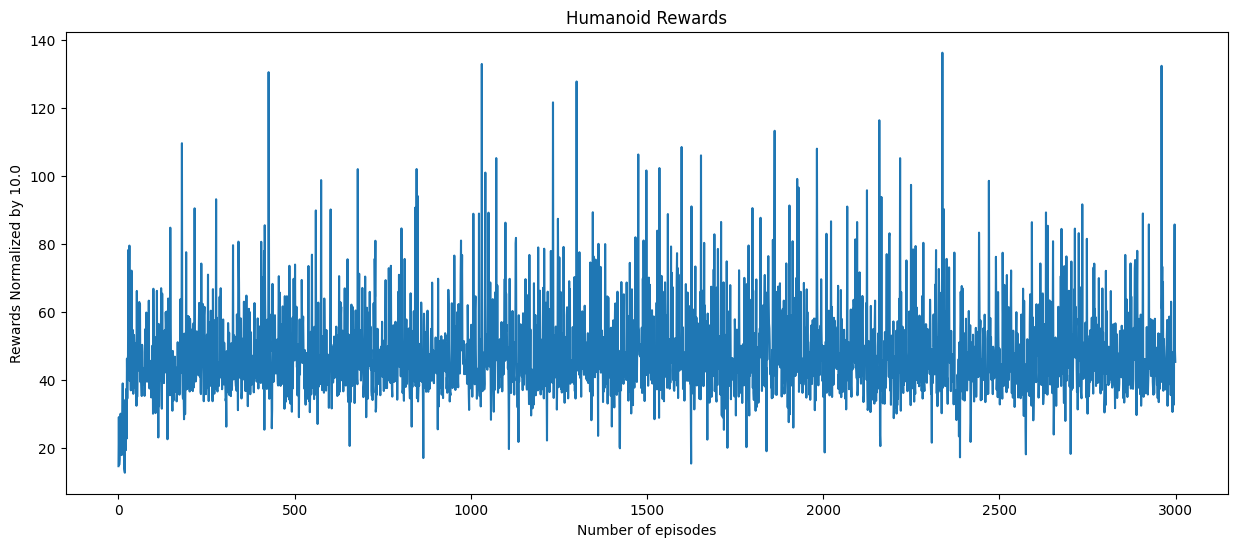

In [18]:
plt.figure(figsize = (15,6))
plt.title('Humanoid Rewards')
plt.xlabel('Number of episodes')
plt.ylabel('Rewards Normalized by 10.0')

plt.plot(episode_reward)

plt.show()